## Construct a Biochemistry-to-Phenotype Model

Here the idea is to approximate the paired oxidation/reduction reactions (as catalyzed by DHFR/TYMS) as a Koshland-Goldbeter-like cycle. We model the steady state concentration of intracellular THF as a balance between two irreversible Michaelis-Menten reactions. The basic steps of model fitting are:
1. Establish a non-linear function relating THF abundance to growth rate (using metabolomics data)
2. Fit a KG model that describes the abundance of THF given the catalytic parameters of DHFR/TYMS
3. Test if this model can describe growth rates over a set of experimentally characterized DHFR and TYMS variants. Perhaps most critically, we observe that this model captures the sign epistasis between DHFR and TYMS.

For the initial model construction and characterization, we first focus on a set of 5 DHFR variants in 2 TYMS backgrounds for which we also have metabolomics measurements. This allows us to directly compare intermediate predictions of our model to metabolite abundances. We then re-fit and evaluate the model on an expanded set of 7 DHFR variants in the background of 4 TYMS variants  (28 combinations in total). The growth rates for these combinations were measured by plate reader assay, in M9 minimal media with 0.4% glucose, 0.2% amicase, and 50 ug/ml thymidine at 30C (the same conditions as our deep mutational scanning data).

April 2023 - K. Reynolds

In [1]:
#%matplotlib notebook
#from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import random
from scipy import stats
from scipy.optimize import least_squares
import pickle
from datetime import date

#set up the plotting environment
import plot_style
plot_style.change_plot_defaults()

### 1. Define key experimental parameters

#### Specify the set of DHFR/TYMS point mutants
Read in and organize experimentally characterized catalytic activities for each variant

In [2]:
DHFR_mut = ['M42F','WT','F31Y','G121V','M42F.G121V','F31Y.G121V','D27N']
TYMS_mut = ['WT','Q33S','R127A','R166Q']
thy = 50

#read in the kinetic parameters for all experimentally characterized DHFR variants
DHFR_kcat, DHFR_Km, DHFR_kcat_std, DHFR_Km_std = {}, {}, {}, {}
flines = open('Input/kinetics_dhfr.txt').readlines()[1:]
for line in flines:
    sp = line.split()
    DHFR_kcat[sp[0]] = float(sp[1])
    DHFR_Km[sp[0]] = float(sp[2])
    if len(sp) < 4:
        DHFR_kcat_std[sp[0]] = np.nan
        DHFR_Km_std[sp[0]] = np.nan
    else:
        DHFR_kcat_std[sp[0]] = float(sp[3])
        DHFR_Km_std[sp[0]] = float(sp[4])

#create focused lists of kinetic parameters including only mutants in the plate reader growth rate assays
dhkcat_sel,dhkm_sel,dhkcat_sel_std, dhkm_sel_std = np.zeros(len(DHFR_mut)),np.zeros(len(DHFR_mut)),\
                                                    np.zeros(len(DHFR_mut)), np.zeros(len(DHFR_mut))
for i,dh in enumerate(DHFR_mut):
    dhkcat_sel[i] = DHFR_kcat[dh]
    dhkm_sel[i] = DHFR_Km[dh]
    dhkcat_sel_std[i] = DHFR_kcat_std[dh]
    dhkm_sel_std[i] = DHFR_Km_std[dh]
                            
#read in the kinetic parameters for all experimentally characterize TYMS variants
TYMS_kcat, TYMS_Km, TYMS_kcat_std, TYMS_Km_std  = {}, {}, {}, {}
flines = open('Input/kinetics_tyms.txt').readlines()[1:]
for line in flines:
    sp = line.split()
    TYMS_kcat[sp[0]] = float(sp[1])
    TYMS_Km[sp[0]] = float(sp[2])
    TYMS_kcat_std[sp[0]] = float(sp[3])
    TYMS_Km_std[sp[0]] = float(sp[4])
    
#create focused lists of kinetic parameters including only mutants in the plate reader growth rate assays
tskcat_sel, tskm_sel, tskcat_sel_std, tskm_sel_std = np.zeros(len(TYMS_mut)), np.zeros(len(TYMS_mut)),\
                                                    np.zeros(len(TYMS_mut)), np.zeros(len(TYMS_mut))
for i,ts in enumerate(TYMS_mut):
    tskcat_sel[i] = TYMS_kcat[ts]
    tskm_sel[i] = TYMS_Km[ts]
    tskcat_sel_std[i] = TYMS_kcat_std[ts]
    tskm_sel_std[i] = TYMS_Km_std[ts]

#### Specifiy metabolomics data 

These data were previously collected in association with Schober et al. (2019) Cell Reports. <br> 
All measurements were made by Jun Park and Li Chen in the Rabinowitz lab. The measurements correspond to relative abundances of 3-glutamate DHF and 3-glutamate 10-formyl-THF. All measurements were previously normalized to cell density and the WT abundance; here we include the mean and standard deviation across biological triplicates. 

In [3]:
#specify the smaller subset of DHFR/TYMS variants associated to metabolomic measurements.
DHFR_met_mut = ['WT','G121V','F31Y.L54I','M42F.G121V','F31Y.G121V']
TYMS_met_mut = ['WT','R166Q']

#the metabolites
formylTHF_3 = np.zeros((len(TYMS_met_mut),len(DHFR_met_mut)),float)
formylTHF_3err = np.zeros_like(formylTHF_3)
DHF_3 = np.zeros_like(formylTHF_3)
DHF_3err = np.zeros_like(formylTHF_3)

#associated doubling times for the cultures used for metabolite extraction
doubtime_thf = np.zeros_like(formylTHF_3)
doubtime_thferr = np.zeros_like(formylTHF_3)
g_rates_thf = np.zeros_like(formylTHF_3)
g_rates_thferr = np.zeros_like(formylTHF_3)


formylTHF_3[0,:] = [1,0.095,0.071,0.029,0.006]
formylTHF_3[1,:] = [1.160,0.439,0.249,0.216,0.089]
formylTHF_3err[0,:] = [0,0.033,0.025,0.009,0.001]
formylTHF_3err[1,:] = [0.173,0.179,0.058,0.070,0.022]
#taking the transpose so the data will be in the same
#N_dhfrmut x N_tymsmut layout as the growth rate data    
formylTHF_3 = formylTHF_3.T 
formylTHF_3err = formylTHF_3err.T

DHF_3[0,:] = [1,18.2,17.6,18.2,14.5]
DHF_3[1,:] = [0.163,1.49,1.05,1.66,2.86]
DHF_3err[0,:] = [0,7.49,6.53,4.97,5.37]
DHF_3err[1,:] = [0.034,0.426,0.160,0.490,1.104]
#taking the transpose so the data will be in the same
#N_dhfrmut x N_tymsmut layout as the growth rate data 
DHF_3 = DHF_3.T
DHF_3err = DHF_3err.T

doubtime_thf[0,:] = [1.39,1.51,1.55,1.76,2.03]
doubtime_thf[1,:] = [1.42,1.45,1.49,1.44,1.49]
doubtime_thferr[0,:] = [0.06,0.09,0.14,0.16,0.13]
doubtime_thferr[1,:] = [0.04,0.06,0.07,0.10,0.09]

#calculate growth rates from the doubling times, and propagate error
g_rates_thf = 1/doubtime_thf
for i in range(len(doubtime_thf)):
    for j in range(len(doubtime_thf[0])):
        g_rates_thferr[i,j] = g_rates_thf[i,j]*(doubtime_thferr[i,j]/doubtime_thf[i,j]) 

#taking the transpose so the data will be in the same
#N_dhfrmut x N_tymsmut layout as the growth rate data 
g_rates_thf = g_rates_thf.T
g_rates_thferr = g_rates_thferr.T
            
#create focused lists of kinetic parameters including only mutants with metabolomics data
dhkcat_met = [DHFR_kcat[dh] for dh in DHFR_met_mut]
dhkm_met = [DHFR_Km[dh] for dh in DHFR_met_mut]
dhkcat_met_std = [DHFR_kcat_std[dh] for dh in DHFR_met_mut]
dhkm_met_std = [DHFR_Km_std[dh] for dh in DHFR_met_mut]

tskcat_met = [TYMS_kcat[ts] for ts in TYMS_met_mut]
tskm_met = [TYMS_Km[ts] for ts in TYMS_met_mut]
tskcat_met_std = [TYMS_kcat_std[ts] for ts in TYMS_met_mut]
tskm_met_std = [TYMS_Km_std[ts] for ts in TYMS_met_mut]

#### 2.  Read in and fit growth rate data for the DHFR/TYMS variants of interest

The data are OD600 measurements recorded over time in a Victor plate reader.
There is one CSV file per 96 well plate, and an additional "plate layout" csv that provides the position of mutants on the 96 well plate. (2 plates total spanning all mutant measurements in triplicate) 

#### Define parameters of the currnet experiment

In [4]:
#stock numbers and shorthand names for individual samples - supplied by Chris Ingle
stockNum = ['453','454','455','456','457','458','459','460','461','463','464','465','466','471',\
            '472','473','474','475','476','478','479','480','481','501','502','503','538','539',\
            '(+)','(-)','M9T','M9CT']

#associated labels for each stock number or shorthand name - in the same order
var = ['WT/WT','WT/R166Q','D27N/WT','F31Y/WT','M42F/WT','G121V/WT','D27N/R166Q','M42F/R166Q','G121V/R166Q',\
      'F31Y.G121V/WT','F31Y.G121V/R166Q','M42F.G121V/WT','M42F.G121V/R166Q','WT/Q33S','D27N/Q33S','F31Y/Q33S',\
      'M42F/Q33S','G121V/Q33S','F31Y.G121V/Q33S','WT/R127A','D27N/R127A','F31Y/R127A','M42F/R127A',\
      'G121V/R127A','F31Y.G121V/R127A','M42F.G121V/R127A','M42F.G121V/Q33S','F31Y/R166Q','WT ER2566',\
      'del/del','M9thy','M9camthy']

#double-check the assignments
print(list(zip(stockNum,var)))

[('453', 'WT/WT'), ('454', 'WT/R166Q'), ('455', 'D27N/WT'), ('456', 'F31Y/WT'), ('457', 'M42F/WT'), ('458', 'G121V/WT'), ('459', 'D27N/R166Q'), ('460', 'M42F/R166Q'), ('461', 'G121V/R166Q'), ('463', 'F31Y.G121V/WT'), ('464', 'F31Y.G121V/R166Q'), ('465', 'M42F.G121V/WT'), ('466', 'M42F.G121V/R166Q'), ('471', 'WT/Q33S'), ('472', 'D27N/Q33S'), ('473', 'F31Y/Q33S'), ('474', 'M42F/Q33S'), ('475', 'G121V/Q33S'), ('476', 'F31Y.G121V/Q33S'), ('478', 'WT/R127A'), ('479', 'D27N/R127A'), ('480', 'F31Y/R127A'), ('481', 'M42F/R127A'), ('501', 'G121V/R127A'), ('502', 'F31Y.G121V/R127A'), ('503', 'M42F.G121V/R127A'), ('538', 'M42F.G121V/Q33S'), ('539', 'F31Y/R166Q'), ('(+)', 'WT ER2566'), ('(-)', 'del/del'), ('M9T', 'M9thy'), ('M9CT', 'M9camthy')]


#### Define functions for reading in the plate data and fitting growth rates

In [5]:
def convertTime(vec_strVals):
    '''Function that converts string-based times recorded in the Victor
       to a numeric value in hours.
       
       Input:
            a vector of string-based time measurement

       Returns a vector of numeric time values in hours.       
    '''
    tHours = []
    tRef = 0
    day = 0
    for i,t in enumerate(vec_strVals):
        if i == 0:
            tHours.append(0)
            sp = t.split(':')
            tRef = float(sp[0])+(float(sp[1])/60)+(float(sp[2])/3600)
        else:
            sp = t.split(':')
            if sp[0] == '00' and tHours[-1] > 20 and day == 0:
                day += 1
                t = float(sp[0])+(float(sp[1])/60)+(float(sp[2])/3600)+(day*24)
            else:
                t = float(sp[0])+(float(sp[1])/60)+(float(sp[2])/3600)+(day*24)
            tHours.append(t - tRef)            
    return np.array(tHours)

def readPlate(fileName, baselineTime):
    '''
    Function that reads a CSV file of Victor plate reader measurements 
    and organizes it into a dictionary (indexed by well) where each
    entry is a (time, OD) measurement tuple. Also performs some basic processing
    to baseline the OD measurements by the average OD recorded during the first
    baselineTime hours.
    
    Input:
        fileName        name of the file to import
        baselineTime    time in hours for computing the baseline OD
        
    Returns a dictionary of (time,OD) tuples organized by well name
    '''
    #read the data from the Victor plate reader into a dataframe
    df_plate = pd.read_csv(fileName)
    wellNames = set(df_plate.Well.values)
    dict_rawODdata, dict_ODdata = {}, {}

    #organize the data into a dictionary, where each entry is keyed by the well name
    #and contains a tuple of time and OD measurement lists
    for well in wellNames:
        dict_rawODdata[well] = ([],[])

    for row in df_plate.iterrows():
        if isinstance(row[1]['Time'],str):
            dict_rawODdata[row[1]['Well']][0].append(row[1]['Time'])
            dict_rawODdata[row[1]['Well']][1].append(row[1]['Absorbance @ 600 (0.5s) (A)'])
        if isinstance(row[1]['Time.1'],str):
            dict_rawODdata[row[1]['Well']][0].append(row[1]['Time.1'])
            dict_rawODdata[row[1]['Well']][1].append(row[1]['Absorbance @ 600 (0.5s) (A).1'])
        if isinstance(row[1]['Time.2'],str):
            dict_rawODdata[row[1]['Well']][0].append(row[1]['Time.2'])
            dict_rawODdata[row[1]['Well']][1].append(row[1]['Absorbance @ 600 (0.5s) (A).2'])
      
    #process the data - convert the time strings into units of hours
    #baseline the data according to the average OD reading during the first baseline_Time hours
    for well in wellNames:
        newT = convertTime(dict_rawODdata[well][0])
        ix_2 = np.argmin(abs(newT - baselineTime))
        newOD = dict_rawODdata[well][1] - np.nanmean(dict_rawODdata[well][1][0:ix_2])
        dict_ODdata[well] = (newT,newOD)
    return dict_ODdata

def readLayout(filename):
    '''
    Reads in a plate layout file saved as CSV 
    and returns a dictionary that is indexed by well
    and contains the content of each well
    '''
    df_layout = pd.read_csv(filename)
    dict_WellLabels = {}
    for row in df_layout.iterrows():
        for i in range(1,len(row[1])):
            if i < 10:
                wellname = row[1][0]+'0'+str(i)
            else:
                wellname = row[1][0]+str(i)
            if row[1][i] in stockNum:
                dict_WellLabels[wellname] = var[stockNum.index(row[1][i])]
    return dict_WellLabels

def fitGrowth(time,OD,startOD,stopOD,stopT):
    '''
    Calculate growth rate by linear regression of the log(OD600) vs time
    data over an interval from startOD to stopOD, where the end point of
    regression must be before stopT
    
    returns the slope and intercept for the line of best fit
    '''
    stopTix = np.argmin(np.abs(time-stopT))
    st = np.argmin(np.abs(OD-startOD))
    end = min(stopTix,np.argmin(np.abs(OD-stopOD)))
    if end > st+5:
        with np.errstate(divide='ignore',invalid='ignore'):
            m,b,r,p,se = stats.linregress(time[st:end],np.log2(OD[st:end]))
    else:
        m = 0
        b = np.mean(OD[0:50])
    return m,b

#### Read in the data and store in a dictionary. 

At this time, we baseline substract the mean OD600 reading over the first 2h of data

In [6]:
grdata_p1 = readPlate('Input/GrowthCurves_PlateReader/230110.csv',2)
layout_p1 = readLayout('Input/GrowthCurves_PlateReader/230110_plate_layout.csv')
grdata_p2 = readPlate('Input/GrowthCurves_PlateReader/230112.csv',2)
layout_p2 = readLayout('Input/GrowthCurves_PlateReader/230112_plate_layout.csv')

expts = [(grdata_p1,layout_p1),(grdata_p2,layout_p2)]
expt_title = ['P1','P2']

#### Fit the growth rates

This is done by linear regression of the log2(OD600) vs time data, considering a fixed OD600 window.<br> 
We plot and visually examine the fits across both 96-well plates

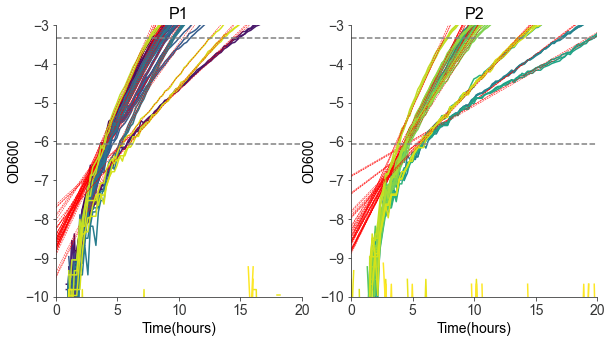

In [7]:
grate_raw = {}

#set up some plotting parameters
viridis = cm.get_cmap('viridis', len(var))
col_list = [viridis(i) for i in np.linspace(0,1,len(var))]

#set the valid OD window and time range 
#for growth rate fitting
startOD = 0.015
stopOD = 0.1
stopT = 20

#iterate over all experiments and wells and fit growth rates
for i,expt in enumerate(expts):
    grate_raw[expt_title[i]] = {}
    for w, well in enumerate(expt[1].keys()):
        gr,icpt = fitGrowth(expt[0][well][0],expt[0][well][1],startOD,stopOD,stopT)
        grate_raw[expt_title[i]][well] = (gr,icpt)

#create log-linear plots of the growth rate fits
plt.figure(figsize = (15,5))
for i,expt in enumerate(expts):
    plt.subplot(1,3,i+1)
    for j,v in enumerate(var):
        wellix = [i for i in expt[1].keys() if expt[1][i] == v]
        for k,well in enumerate(wellix):
            if k == 0:
                with np.errstate(divide='ignore',invalid='ignore'):
                    plt.plot(expt[0][well][0],np.log2(expt[0][well][1]),color=col_list[j],label=v)
                plt.plot(expt[0][well][0],\
                         expt[0][well][0]*grate_raw[expt_title[i]][well][0]+grate_raw[expt_title[i]][well][1],\
                         '--r',linewidth=0.5)
            else:
                with np.errstate(divide='ignore',invalid='ignore'):
                    plt.plot(expt[0][well][0],np.log2(expt[0][well][1]),color=col_list[j])
                plt.plot(expt[0][well][0],\
                         expt[0][well][0]*grate_raw[expt_title[i]][well][0]+grate_raw[expt_title[i]][well][1],\
                         '--r',linewidth=0.5)
    #plt.legend()
    plt.plot([0,20],[np.log2(startOD),np.log2(startOD)],'--',color='grey')
    plt.plot([0,20],[np.log2(stopOD),np.log2(stopOD)],'--',color='grey')
    plt.ylim([-10,-3])
    plt.xlim([0,20])
    plt.xlabel('Time(hours)',fontsize=14)
    plt.ylabel('OD600', fontsize=14)
    plt.title(expt_title[i],fontsize=16)

#### Organize the growth rate data 
Growth rates (the slope of the line) are stored in a numpy matrix (g_rates_mean) with dimensions of N_DHFRmut, N_TYMSmut (7 x 4). Associated standard deviations (computed from technical triplicates) are stored in g_rates_std

In [8]:
g_rates_mean_notnorm = np.zeros((len(DHFR_mut),len(TYMS_mut)))
g_rates_std = np.zeros_like(g_rates_mean_notnorm)

for i,dhmut in enumerate(DHFR_mut):
    for j,tsmut in enumerate(TYMS_mut):
        combo = dhmut+'/'+tsmut
        e_title = ''
        wells = []
        for e,et in enumerate(expt_title):
            if combo in expts[e][1].values():
                e_title = et
                for v,val in enumerate(expts[e][1].values()):
                    if val == combo:
                        wells.append(list(expts[e][1].keys())[v])
        gr = [grate_raw[e_title][k][0] for k in wells]
        g_rates_mean_notnorm[i,j] = np.mean(gr)
        g_rates_std[i,j] = np.std(gr)
        #normalize the data so that the WT growth rate is 1.0
        g_rates_mean = g_rates_mean_notnorm/g_rates_mean_notnorm[1,0]

<ipython-input-8-a9c052015c29>:19: RuntimeWarning: divide by zero encountered in true_divide
  g_rates_mean = g_rates_mean_notnorm/g_rates_mean_notnorm[1,0]
<ipython-input-8-a9c052015c29>:19: RuntimeWarning: invalid value encountered in true_divide
  g_rates_mean = g_rates_mean_notnorm/g_rates_mean_notnorm[1,0]


#### Plot growth rate vs. enzymatic velocity at 25uM DHF 

This provides a summary of the growth rate data for all seven DHFR mutants in each of the TYMS backgrounds. We use 25 uM DHF because this is close to the intracellular DHF concentration for WT E. coli

We see that R166Q TYMS is broadly rescing, R127A TYMS as a less substantial buffering effect, and that Q33S - at least in some cases - is deleterious or aggravating.

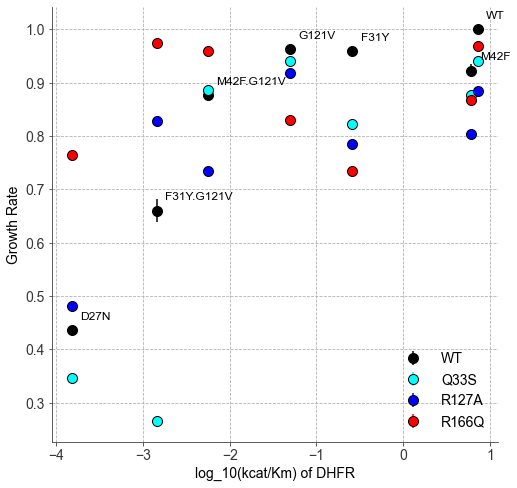

In [9]:
plt.rcParams['figure.figsize'] = 8,8

kcKm = [kc/dhkm_sel[i] for i,kc in enumerate(dhkcat_sel)]
ts_col = ['black','cyan','blue','red']
for i in range(len(ts_col)):
    plt.errorbar(np.log10(kcKm),g_rates_mean[:,i],yerr=g_rates_std[:,i],fmt='o',color=ts_col[i],mec='k',\
                 ms=10,label=TYMS_mut[i])
    
for i,mut in enumerate(DHFR_mut):
    plt.text(np.log10(kcKm[i])+0.1,g_rates_mean[i,0]+0.02,mut,fontsize=12)

plt.xlabel('log_10(kcat/Km) of DHFR',fontsize=14)
plt.ylabel('Growth Rate', fontsize=14)
plt.legend()
plt.grid(linestyle='--')
plt.savefig('Figs/GrowthData_PlateReader.pdf')

In [10]:
plate_grdata  = {}
plate_grdata['DHmut'] = DHFR_mut
plate_grdata['TSmut'] = TYMS_mut
plate_grdata['gr_mean'] = g_rates_mean
plate_grdata['gr_std'] = g_rates_std
 
today = date.today()    
fout = open(f'Output/{today}_plate_grdata.pkl', 'wb')
pickle.dump(plate_grdata,fout, protocol=pickle.HIGHEST_PROTOCOL)
fout.close()

**** This completes setting up the input data (kinetic parameters, metabolomics and growth rate measurements) ****

### 3. Specify the model and fitting functions

In [11]:
def gr_depSigmoid(K,n,gmax,gmin,metab):
    '''
    Sigmoidal function relating metabolite concentration to growth rate.
    
    **Arguments:**
        K = metabolite concetration at 50% of maximal growth
        n = hill coefficient
        gmax = max growth rate
        gmin = min growth rate
        metab = metabolite concetrations
    '''
    gr = (gmax - gmin)/(1 + (K/metab)**n) + gmin
    return gr

def concTHF(Ftot,c_ts,c_dh,kc_ts,kc_dh,km_ts,km_dh):
    '''
    Calculate the steady state concentration of THF 
    using the Koshland-Goldbeter equation
    
    Returns the fraction of the total folate pool that
    corresponds to THF
    
    **Arguments:**
        Ftot = total folate pool
        c_ts = relative abundance of TYMS
        c_dh = relative abundace of DHFR
        kc_ts = kcat TYMS
        kc_dh = kcat DHFR
        km_ts = Km TYMS
        km_dh = Km DHFR
    '''
    v1 = kc_dh*c_dh
    v2 = kc_ts*c_ts
    km1 = km_dh/Ftot
    km2 = km_ts/Ftot
    p1 = (v1/v2)*(1-km2) - km1 - 1
    p2 = np.sqrt(4*km2*(v1/v2)*(v1/v2 - 1) + ((v1/v2)*(km2 - 1)+km1 + 1)**2)
    fracTHF = (p1 + p2)/(2*(v1/v2 - 1))
    return fracTHF
    
def calcGR(Ftot,c_ts_wt, c_ts,c_dh,kc_tsmut,kc_dhmut,km_tsmut,km_dhmut,g_params):
    '''
    Calculate the growth rate for select DHFR and TYMS mutant combinations
    given parameters for the KG model and THF-growth rate relationship.
    
    **Arguments:**
        Ftot = total folate pool
        c_ts = relative abundance of TYMS
        c_dh = relative abundace of DHFR
        kc_tsmut = kcat TYMS
        kc_dhmut = kcat DHFR
        km_tsmut = Km TYMS
        km_dhmut = Km DHFR
        g_params = array of four parameters for gr_depSigmoid (K,n,gmax,gmin)
    
    returns the estimated growth rates as either a scalar, array, or Ndh * Nts 
    matrix, depending on the number of input DHFR and TYMS kinetic parameters
    '''
    K,n,gmax,gmin = g_params
    
    #calculate a growth rate matrix
    if hasattr(kc_tsmut, "__len__") and hasattr(kc_dhmut, "__len__"):
        gr = np.zeros((len(kc_dhmut),len(kc_tsmut)))
        thfWT = concTHF(Ftot,c_ts_wt,c_dh,TYMS_kcat['WT'],DHFR_kcat['WT'],TYMS_Km['WT'],DHFR_Km['WT'])
        for i in range(len(kc_dhmut)):
            for j in range(len(kc_tsmut)):
                thfMut = concTHF(Ftot,c_ts[j],c_dh,kc_tsmut[j],kc_dhmut[i],km_tsmut[j],km_dhmut[i])
                relTHF = thfMut/thfWT
                gr[i,j] =gr_depSigmoid(K,n,gmax,gmin,relTHF)
        return gr
    
    #calculate a growth rate vector
    elif hasattr(kc_tsmut, "__len__") and not(hasattr(kc_dhmut, "__len__")):
        gr = np.zeros(len(kc_tsmut))
        thfWT = concTHF(Ftot,c_ts_wt,c_dh,TYMS_kcat['WT'],DHFR_kcat['WT'],TYMS_Km['WT'],DHFR_Km['WT'])
        for j in range(len(kc_tsmut)):
            thfMut = concTHF(Ftot,c_ts[j],c_dh,kc_tsmut[j],kc_dhmut,km_tsmut[j],km_dhmut)
            relTHF = thfMut/thfWT
            gr[j] = gr_depSigmoid(K,n,gmax,gmin,relTHF)
        return gr
    
    #calculate a single growth rate value
    else:
        thfMut = concTHF(Ftot,c_ts,c_dh,kc_tsmut,kc_dhmut,km_tsmut,km_dhmut)
        thfWT = concTHF(Ftot,c_ts_wt,c_dh,TYMS_kcat['WT'],DHFR_kcat['WT'],TYMS_Km['WT'],DHFR_Km['WT'])
        relTHF = thfMut/thfWT
        gr = gr_depSigmoid(K,n,gmax,gmin,relTHF)
        return gr


def resids_grSigmoid(p,obs_g_rates,metab):
    '''
    Calculate the difference between the observed and calculated 
    growth rates, given a set of metabolite concentrations and choice
    of growth rate parameters. Used to fit the sigmoidal THF-growth relationship.
    
    **Arguments:**
        p = array of growth rate fit parameters (K,n,gmax,gmin)
        obs_g_rates = experimentally observed growth rates
        metab = metabolite concentrations
    '''
    K,n,mx,mn = p
    gr = np.array([gr_depSigmoid(K,n,mx,mn,m) for m in metab])
    err = gr - obs_g_rates
    return err

def resids_relTHF(p,kc_ts,kc_dh,km_ts,km_dh,obs_thf,holdout=np.nan):
    '''
    Calculate the difference between the observed and calculated
    THF concentrations, given a set of DHFR and TYMS catalytic parameters.
    Used to fit the KG equation parameters.
    
    **Arguments:**
        p = array of fit parameters for the KG equation (Ftot,c_ts,c_dh)
        kc_ts = kcat TYMS
        kc_dh = kcat DHFR
        km_ts = Km TYMS
        km_dh = Km DHFR
        obs_thf = observed THF concentrations,arranged in an Ndh x Nts matrix
        holdout = (optional) data point to exclude during fitting
        
    The holdout parameter is used to estimate sensitivity of the model fit parameters
    on the dataset (by excluding a single data point when fitting the data)
    
    The function assumes that observed THF concentrations (rows) match to the 
    dhfr variants as ordered in kc_dh/km_dh, and that the (columns) match to the 
    tyms variants as ordered in kc_ts/km_ts. 
    
    The function also expects to fit tyms-dependent values of the relative TYMS
    concentration (c_ts) but a single relative DHFR concentration
    ''' 
    Ftot = p[0]
    c_ts = p[1:3]
    c_dh = p[3]
    calc_thf = np.zeros((len(kc_dh),len(kc_ts)))
    thfWT = concTHF(Ftot,c_ts[0],c_dh,TYMS_kcat['WT'],DHFR_kcat['WT'],\
                    TYMS_Km['WT'],DHFR_Km['WT'])
    for i,d in enumerate(kc_dh):
        for j,t in enumerate(kc_ts):
            calc_thf[i,j] = concTHF(Ftot,c_ts[j],c_dh,t,d,km_ts[j],km_dh[i])/thfWT
    if np.isnan(holdout):
        err = np.log10(obs_thf.flatten()) - np.log10(calc_thf.flatten())
    else:
        err = np.log10(np.delete(obs_thf,holdout)) - np.log10(np.delete(calc_thf,holdout))
    return err
    
def resids_grates(p,kc_ts,kc_dh,km_ts,km_dh,obs_grates,holdout=np.nan,cts='mult'):
    '''
    Calculate the difference between the observed and calculated
    growth rates, given a set of DHFR and TYMS catalytic parameters, 
    and selected fit parameters (p). Used to fit the complete set of 
    model parameters from a growth rate dataset. 
    
    **Arguments: **
        p = array of fit parameters (Ftot,cts,cdh,parameters for growth rate sigmoid)
        kc_ts = kcat TYMS
        kc_dh = kcat DHFR
        km_ts = Km TYMS
        km_dh = Km DHFR
        obs_grates = observed (experimental) growth rates
        holdout = (optional) data point to exclude during fitting
        cts = (optional) argument to specify if you wish to only fit a subset of tyms concentration values
              'mult' fits a tyms concentration for each mutant
              'two' fits two tyms concentrations - one for R166Q and one for everything else
               any other string results in fitting only a single tyms concentration parameter
    
    The holdout parameter is used to estimate sensitivity of the model fit parameters
    on the dataset (by excluding a single data point when fitting the data)
    
    The function assumes that the observed growth rates are organized such that the
    (rows) match to the dhfr variants as orderd in kc_dh and km_dh, and that the 
    (columns) match to the tyms variants as ordered in kc_ts and km_ts
    '''
    
    #select whether to fit: (1) a unique relative concentration of TYMS for each
    #TYMS variant, OR (2) a relative concentration for TYMS R166Q and a single parameter for
    #all of the others OR (3) a single relative concentration of TYMS for all variants (one parameter)
    if (cts=='mult'):
        Ftot = p[0]
        cts =p[1:1+len(kc_ts)]
        cdh=p[1+len(kc_ts)]
        g_params = p[len(kc_ts)+2:]
    
    elif (cts == 'two'):
        Ftot = p[0]
        cts =np.ones(len(kc_ts))*p[1]
        cts[-1] = p[2]
        cdh=p[3]
        g_params = p[4:]
    
    else: 
        Ftot = p[0]
        cts =np.ones(len(kc_ts))*p[1]
        cdh=p[2]
        g_params = p[3:]
        
    gr_est = calcGR(Ftot,cts[0],cts,cdh,kc_ts,kc_dh,km_ts,km_dh,g_params)
    
    if np.isnan(holdout):
        err = gr_est.flatten() - obs_grates.flatten()
    else:
        err = np.delete(gr_est,holdout) - np.delete(obs_grates,holdout)
    return err


### 4. Develop the Koshland-Goldbeter based model for a limited set of mutations where we also have metabolomics data

Now to start, we develop the model in parts, relying on a more limited set of point mutants (5 DHFR mutations in two TYMS backgrounds, 10 total data points) for which we also have metabolomics data. Here the idea is to see if the functional form of the model makes sense/describes the data well. 

Afterwards (later in the notebook) we evaluate model performance across all of the plate reader data (7 DHFR mutations in 4 TYMS backgrounds, 28 total data points) 

#### Fit a model describing the relationship between THF and growth rate

Best fit for mapping thf to growth rate - K: 0.04, n: 1.58, mx: 0.70, mn: 0.48


<ipython-input-11-892c93f6ab8f>:12: RuntimeWarning: divide by zero encountered in double_scalars
  gr = (gmax - gmin)/(1 + (K/metab)**n) + gmin


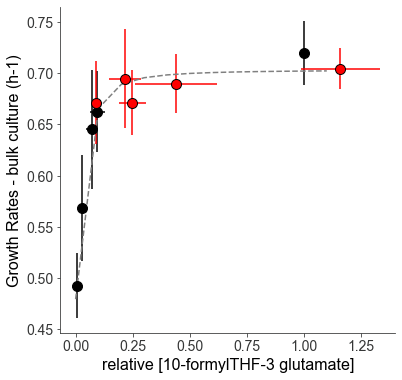

In [12]:
p0 = [0.1,2,1,0]
thf_fit = least_squares(resids_grSigmoid,p0,args=(g_rates_thf.flatten(),formylTHF_3.flatten()))
print('Best fit for mapping thf to growth rate - K: %1.2f, n: %1.2f, mx: %1.2f, mn: %1.2f' % (thf_fit.x[0],thf_fit.x[1],thf_fit.x[2],thf_fit.x[3]))
K,n,mx,mn = thf_fit.x

plt.rcParams['figure.figsize'] = 6,6
plt.errorbar(formylTHF_3[:,0].flatten(),g_rates_thf[:,0].flatten(),xerr=formylTHF_3err[:,0].flatten(),\
             yerr=g_rates_thferr[:,0].flatten(),marker='o',color='k',markersize=10,linestyle='')
plt.errorbar(formylTHF_3[:,1].flatten(),g_rates_thf[:,1].flatten(),xerr=formylTHF_3err[:,1].flatten(),\
             yerr=g_rates_thferr[:,1].flatten(),marker='o',color='r',mec='k',markersize=10,linestyle='')

plt.plot(np.arange(0,1.2,0.1),[gr_depSigmoid(thf_fit.x[0],thf_fit.x[1],thf_fit.x[2],thf_fit.x[3],x) for x in np.arange(0,1.2,0.1)],'--',color='grey')
plt.xlabel('relative [10-formylTHF-3 glutamate]',fontsize=16)
plt.ylabel('Growth Rates - bulk culture (h-1)', fontsize=16)
plt.savefig('Figs/GrowthRate_THF.pdf')

#### Fit the Koshland Goldbeter model describing THF abundance given DHFR and TYMS activity

Use bootstrapping to assess the error in the fit THF values.

Best fit for mapping catalytic parameters to thf - Ftot: 8.54E+00 (+/-3.70E+00), TYMS 1: 0.12 (+/-0.01),     TYMS 2: 77.29 (+/-7.76), DHFR: 0.32 (+/-0.04)


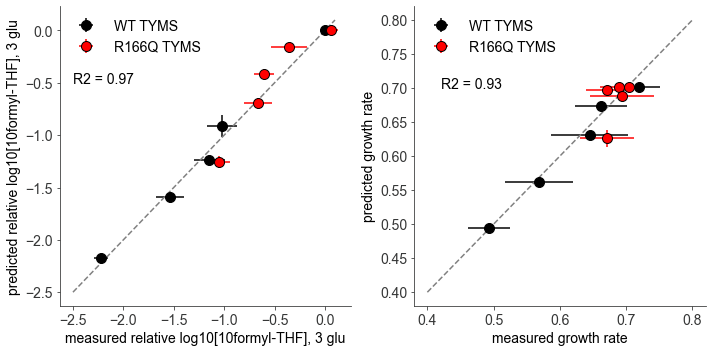

In [13]:
p0 = [1,1,1,0.1]
bds = ([1E-5,1E-5,1E-5,1E-5],[100,100,100,100])

#first complete a fit with all of the data
kg_fit_all = least_squares(resids_relTHF,p0,args=(tskcat_met,dhkcat_met,tskm_met,dhkm_met,formylTHF_3),bounds = bds)
Ftot = kg_fit_all.x[0]
c_ts_1,c_ts_2 = kg_fit_all.x[1],kg_fit_all.x[2]
c_ts = [kg_fit_all.x[1],kg_fit_all.x[2]]
c_dh = kg_fit_all.x[3]

#evaluate the [thf] and growth rates with the best fit parameters
thf_pred = np.zeros((len(dhkcat_met),len(tskcat_met)))
dhf_pred = np.zeros((len(dhkcat_met),len(tskcat_met)))
gr_pred = np.zeros((len(dhkcat_met),len(tskcat_met)))
thfWT = concTHF(Ftot,c_ts[0],c_dh,TYMS_kcat['WT'],DHFR_kcat['WT'],\
                TYMS_Km['WT'],DHFR_Km['WT'])
dhfWT = 1 - thfWT
for j,d in enumerate(dhkcat_met):
    for k,t in enumerate(tskcat_met):
        thf_pred[j,k] = concTHF(Ftot,c_ts[k],c_dh,t,d,tskm_met[k],dhkm_met[j])/thfWT
        gr_pred[j,k] = gr_depSigmoid(K,n,mx,mn,thf_pred[j,k])
        dhf_pred[j,k] = (1 - (thf_pred[j,k]*thfWT))/dhfWT
        
#JACKKNIFE ANALYSIS
#to get a sense of fit sensitivity, fit repeatedly, leaving out one mutant at a time
Nsamp = (len(dhkcat_met) * len(tskcat_met))
Ftot_samp = np.zeros((Nsamp,1))
c_ts_samp = np.zeros((Nsamp,2))
c_dh_samp = np.zeros((Nsamp,1))

for i in range(Nsamp):
    kg_fit = least_squares(resids_relTHF,p0,args=(tskcat_met,dhkcat_met,tskm_met,dhkm_met,formylTHF_3,i),bounds = bds)
    if kg_fit.success:
        Ftot_samp[i] = kg_fit.x[0]
        c_ts_samp[i] = [kg_fit.x[1],kg_fit.x[2]]
        c_dh_samp[i] = kg_fit.x[3]
    else:
        Ftot_samp[i] = np.nan
        c_ts_samp[i] = np.nan
        c_dh_samp[i] = np.nan
        
#calculate mean and stdev in fit parameters
Ftot_mean, Ftot_std = np.nanmean(Ftot_samp),np.nanstd(Ftot_samp)
c_ts_1_mean, c_ts1_std = np.nanmean(c_ts_samp[:,0]),np.nanstd(c_ts_samp[:,0])
c_ts_2_mean, c_ts2_std = np.nanmean(c_ts_samp[:,1]),np.nanstd(c_ts_samp[:,1])
c_dh_mean, c_dh_std = np.nanmean(c_dh_samp),np.nanstd(c_dh_samp)

print('Best fit for mapping catalytic parameters to thf - Ftot: %1.2E (+/-%1.2E), TYMS 1: %1.2f (+/-%1.2f), \
    TYMS 2: %1.2f (+/-%1.2f), DHFR: %1.2f (+/-%1.2f)' % (Ftot_mean,Ftot_std,c_ts_1_mean,c_ts1_std,c_ts_2_mean,c_ts2_std,\
                                                         c_dh_mean,c_dh_std))

#now, given the leave-one-out fit parameters, estimate the values for thf and growth rate
thf_pred_samp = np.zeros((Nsamp,len(dhkcat_met),len(tskcat_met)))
dhf_pred_samp = np.zeros_like(thf_pred_samp)
gr_pred_samp = np.zeros((Nsamp,len(dhkcat_met),len(tskcat_met)))

for i in range(Nsamp):
    thfWT = concTHF(Ftot_samp[i],c_ts_samp[i,0],c_dh_samp[i],TYMS_kcat['WT'],DHFR_kcat['WT'],\
                    TYMS_Km['WT'],DHFR_Km['WT'])
    dhfWT = 1 - thfWT
    if Ftot_samp[i] == np.nan:
        thf_pred_samp[i,j,k] = np.nan
        gr_pred_samp[i,j,k] = np.nan
    else:
        for j,d in enumerate(dhkcat_met):
                for k,t in enumerate(tskcat_met):
                    thf_pred_samp[i,j,k] = concTHF(Ftot_samp[i],c_ts_samp[i,k],c_dh_samp[i],t,d,\
                                               tskm_met[k],dhkm_met[j])/thfWT
                    dhf_pred_samp[i,j,k] = (1 - (thf_pred_samp[i,j,k]*thfWT))/dhfWT
                    gr_pred_samp[i,j,k] = gr_depSigmoid(K,n,mx,mn,thf_pred_samp[i,j,k])
            
#calculate mean and error in predictions 
thf_pred_mean,thf_pred_err = np.nanmean(thf_pred_samp,0),np.nanstd(thf_pred_samp,0)
dhf_pred_mean,dhf_pred_err = np.mean(dhf_pred_samp,0),np.std(dhf_pred_samp,0)
gr_pred_mean,gr_pred_err = np.nanmean(gr_pred_samp,0),np.nanstd(gr_pred_samp,0)

#scaling error in THF abundance appropriately for log10-scale plots
thf_pred_err_log = np.zeros_like(thf_pred_err)
formylTHF_err_log = np.zeros_like(formylTHF_3err)
for i in range(len(dhkcat_met)):
    for j in range(len(tskcat_met)):
        thf_pred_err_log[i,j] = (0.434)*thf_pred_err[i,j]/thf_pred[i,j] 
        formylTHF_err_log[i,j] = (0.434)*formylTHF_3err[i,j]/formylTHF_3[i,j] 

        
#### Plotting ####        
plt.rcParams['figure.figsize'] = 10,5
#plot of predicted vs actual THF abundance
#plotting the predictions with the best fit parameters across all data
plt.subplot(121)
plt.errorbar(np.log10(formylTHF_3[:,0]),np.log10(thf_pred_mean[:,0]),xerr=formylTHF_err_log[:,0],\
             yerr=thf_pred_err_log[:,0],marker='o',color='k',markersize=10,linestyle='',label='WT TYMS')
plt.errorbar(np.log10(formylTHF_3[:,1]),np.log10(thf_pred_mean[:,1]),xerr=formylTHF_err_log[:,1],\
             yerr=thf_pred_err_log[:,1],marker='o',color='r',mec='k',markersize=10,linestyle='',label='R166Q TYMS')
plt.plot([-2.5,0.1],[-2.5,0.1],linestyle='--',color='grey')
r_thf = np.corrcoef(np.log10(formylTHF_3.flatten()),np.log10(thf_pred_mean.flatten()))[0,1]
plt.text(-2.5,-0.5,'R2 = %1.2f' % r_thf**2, fontsize=14)
plt.legend()
plt.xlabel('measured relative log10[10formyl-THF], 3 glu', fontsize=14)
plt.ylabel('predicted relative log10[10formyl-THF], 3 glu', fontsize=14)

#plot of predicted vs actual growth rate
plt.subplot(122)
plt.errorbar(g_rates_thf[:,0],gr_pred_mean[:,0],xerr=g_rates_thferr[:,0],
             yerr=gr_pred_err[:,0], marker='o',color='k',markersize=10,linestyle='',label='WT TYMS')
plt.errorbar(g_rates_thf[:,1],gr_pred_mean[:,1],xerr=g_rates_thferr[:,1],
             yerr=gr_pred_err[:,1],marker='o',color='r',mec='k',markersize=10,linestyle='',label='R166Q TYMS')
plt.plot([0.4,0.8],[0.4,0.8],linestyle='--',color='grey')
r_gr_metabs = np.corrcoef(g_rates_thf.flatten(),gr_pred_mean.flatten())[0,1]
plt.text(0.42,0.7,'R2 = %1.2f' % r_gr_metabs**2, fontsize=14)
plt.legend()
plt.xlabel('measured growth rate', fontsize=14)
plt.ylabel('predicted growth rate', fontsize=14)

plt.tight_layout()
plt.savefig('Figs/PredTHFGR_SchoberData.pdf')

Generate some heatmaps of the predicted and experimental metabolite abundances... we see good qualitative agreement, though DHF accumulation is overpredicted by the model. 

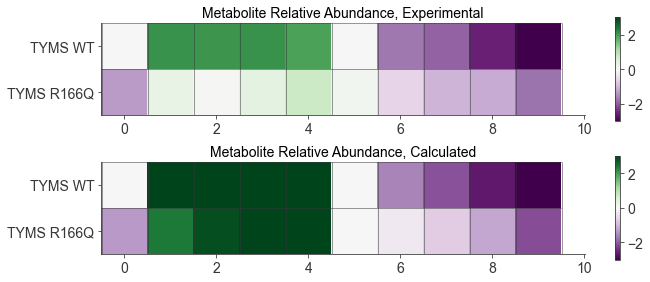

In [14]:
metab_meas = np.vstack((np.log(DHF_3)/np.log(4),np.log(formylTHF_3)/np.log(4)))
metab_pred = np.vstack((np.log(dhf_pred)/np.log(4),np.log(thf_pred)/np.log(4)))

plt.figure(num='h1',figsize=(10,4))
plt.subplot(211)
plt.imshow(metab_meas.T,cmap='PRGn',vmin=-3,vmax=3)
plot_style.grid_maker(metab_meas.T,'h1')
plt.colorbar()
plt.yticks(np.arange(2),labels=['TYMS WT','TYMS R166Q'])
plt.title('Metabolite Relative Abundance, Experimental',fontsize=14)


plt.subplot(212)
plt.imshow(metab_pred.T,cmap='PRGn',vmin=-3,vmax=3)
plot_style.grid_maker(metab_pred.T,'h1')
plt.colorbar()
plt.yticks(np.arange(2),labels=['TYMS WT','TYMS R166Q'])
plt.title('Metabolite Relative Abundance, Calculated',fontsize=14)
plt.tight_layout()

plt.savefig('Figs/MetPrediction.pdf')

### 5. Fit the model on the complete set of DHFR point mutations in four TYMS backgrounds

In this case, we have more data, because we've got real steady state kinetics measurements for two other TYMS variants. This brings the total number of data points up to seven DHFR variants in four TYMS backgrounds. We don't have metabolomics measurements though, so we have to fit on growth rate directly.

In [15]:
#initial parameter guesses for:
#total folate pool, relative [TYMS], relative [DHFR], K, n, max, min 
#these last four parameters set the relationship between folate abundance and growth rate.
p0 = [1,0.1,0.1,0.1,0.1,0.1,0.04,1.6,1,0.1]
#p0 = [5.4713,0.14,0.27,0.93,0.33,0.08,0.036,1.57,1.02,0.19]
bds = ([1E-5,1E-5,1E-5,1E-5,1E-5,1E-5,0.001,0,0.6,0],[100,100,100,100,100,100,5,10,1.5,0.2])


#### SINGLE FIT ON COMPLETE DATA SET
#kg_all_fit2 = least_squares(resids_grates2,p0,args=(tskcat_sel,dhkcat_sel,tskm_sel,dhkm_sel,\
#                                                  g_rates_mean[5,:,:]),bounds=bds)
#Ftot_all2 = kg_all_fit2.x[0]
#c_ts_all2 = kg_all_fit2.x[1]
#c_dh_all2 = kg_all_fit2.x[2]
#g_params_all2 = kg_all_fit2.x[3:]
#gr_pred_allfit2 = calcGR(Ftot_all2,c_ts_all2,c_dh_all2,tskcat_sel,dhkcat_sel,tskm_sel,dhkm_sel,g_params_all2)

#### JACKKNIFE (leave one out) ANALYSIS
N_meas = len(dhkcat_sel) * len(tskcat_sel)
Nsamp = N_meas
Ftot_all2samp =np.zeros((Nsamp,1))
c_ts_all2samp = np.zeros((Nsamp,4))
c_dh_all2samp = np.zeros((Nsamp,1))
g_params_all2samp = np.zeros((Nsamp,4))
gr_pred_allfit2samp = np.zeros((Nsamp,len(dhkcat_sel),len(tskcat_sel)))

for i in range(Nsamp):
    kg_all_fit2 = least_squares(resids_grates,p0,\
                                args=(tskcat_sel,dhkcat_sel,tskm_sel,dhkm_sel,g_rates_mean,i),\
                                bounds=bds)
    if kg_all_fit2.success:
        Ftot_all2samp[i] = kg_all_fit2.x[0]
        c_ts_all2samp[i,:] = kg_all_fit2.x[1:5]
        c_dh_all2samp[i] = kg_all_fit2.x[5]
        g_params_all2samp[i,:] = kg_all_fit2.x[6:]
        
        gr_pred_allfit2samp[i,:,:] = calcGR(Ftot_all2samp[i],c_ts_all2samp[i,0],c_ts_all2samp[i,:],c_dh_all2samp[i],\
                                            tskcat_sel,dhkcat_sel,tskm_sel,dhkm_sel,g_params_all2samp[i,:])
    
#calculate means and error on the parameters
Ftot_all2, Ftot_all2_std = np.mean(Ftot_all2samp),np.std(Ftot_all2samp)
c_ts_all2, c_ts_all2_std = np.mean(c_ts_all2samp,0),np.std(c_ts_all2samp,0)
c_dh_all2, c_dh_all2_std = np.mean(c_dh_all2samp),np.std(c_dh_all2samp)
g_params_all2, g_params_all2_err = np.mean(g_params_all2samp,0),np.std(g_params_all2samp,0)

#and report the best fit values:
print('Best fit for mapping catalytic parameters to thf - Ftot: %1.2f (+/-%1.2f), TYMS: %1.2f (+/-%1.2f),\
    %1.2f (+/-%1.2f),%1.2f (+/-%1.2f),%1.2f (+/-%1.2f),\
    DHFR: %1.2f (+/-%1.2f), K: %1.2f (+/-%1.2f),n:%1.2f (+/-%1.2f), mx:%1.2f (+/-%1.2f), \
    mn: %1.2f (+/-%1.2f)' % (Ftot_all2,Ftot_all2_std,c_ts_all2[0],c_ts_all2_std[0],c_ts_all2[1],c_ts_all2_std[1],\
                             c_ts_all2[2],c_ts_all2_std[2],c_ts_all2[3],c_ts_all2_std[3],c_dh_all2,c_dh_all2_std,\
                            g_params_all2[0],g_params_all2_err[0],g_params_all2[1],g_params_all2_err[1],\
                            g_params_all2[2],g_params_all2_err[2],g_params_all2[3],g_params_all2_err[3]))


#calculate means and error on growth rates
gr_pred_allfit2, gr_pred_allfit2_err = np.mean(gr_pred_allfit2samp,0),np.std(gr_pred_allfit2samp,0)

#assess fit quality using the mean growth rates
rmsd_allfit2 = np.sqrt(np.sum((gr_pred_allfit2 - g_rates_mean)**2)/N_meas)
r2_allfit2 = np.corrcoef(g_rates_mean.flatten(),gr_pred_allfit2.flatten())[0,1]**2
print('*** RMSD between the model and data - using refit params for full model: %1.2f' % rmsd_allfit2)
print('*** R2: %1.2f' % r2_allfit2)

Best fit for mapping catalytic parameters to thf - Ftot: 95.43 (+/-19.06), TYMS: 0.08 (+/-0.10),    0.28 (+/-0.34),0.23 (+/-0.27),21.18 (+/-5.47),    DHFR: 3.16 (+/-3.91), K: 0.65 (+/-0.25),n:0.62 (+/-0.35), mx:1.41 (+/-0.21),     mn: 0.20 (+/-0.00)
*** RMSD between the model and data - using refit params for full model: 0.08
*** R2: 0.84


*** RMSD between the modeled epistasis and the data - using refit params for full model: 0.07
*** R2: 0.72


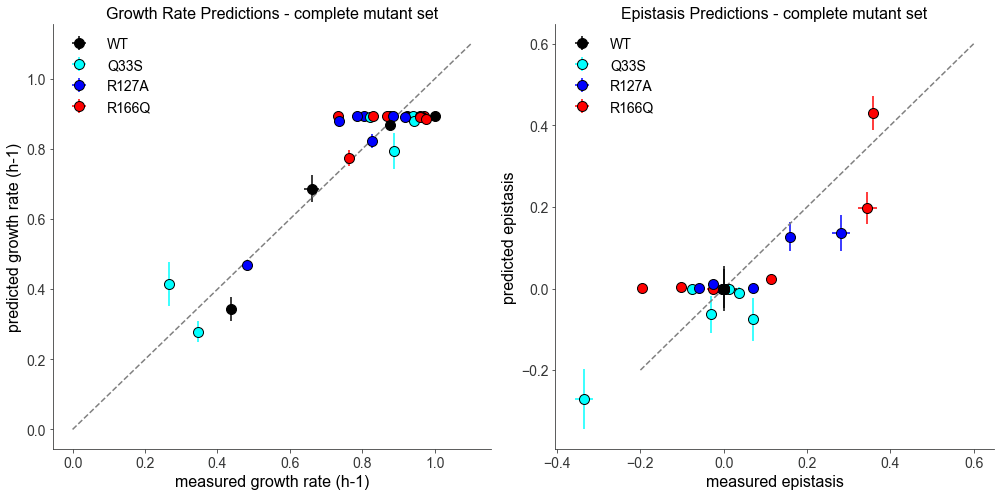

In [16]:
plt.figure(figsize=(14,7))

########### plot of predicted vs actual growth rate
plt.subplot(121)
for i,dmut in enumerate(DHFR_mut):
    for k,tmut in enumerate(TYMS_mut):
        if i==0:
            plt.errorbar(g_rates_mean[i,k],gr_pred_allfit2[i,k],xerr=g_rates_std[i,k],
                     yerr = gr_pred_allfit2_err[i,k],marker='o',mec='k',color=ts_col[k],markersize=10,
                         linestyle='',label=tmut)
            #plt.text(g_rates_mean[i,k],gr_pred_allfit2[i,k],dmut)
        else:
            plt.errorbar(g_rates_mean[i,k],gr_pred_allfit2[i,k],xerr=g_rates_std[i,k],
                     yerr = gr_pred_allfit2_err[i,k],marker='o',mec='k',color=ts_col[k],markersize=10,
                         linestyle='')
            #plt.text(g_rates_mean[5,i,k]+.03,gr_pred_allfit2[i,k]+0.03,dmut)
plt.legend()
plt.plot([0,1.1],[0,1.1],'--',color='grey')
plt.title('Growth Rate Predictions - complete mutant set', fontsize=16)
plt.xlabel('measured growth rate (h-1)', fontsize=16)
plt.ylabel('predicted growth rate (h-1)', fontsize=16)

########### plot of predicted vs actual epistasis
# calculate epistasis
epi_meas = np.zeros((len(DHFR_mut),len(TYMS_mut)))
epi_meas_err = np.zeros_like(epi_meas)
epi_pred = np.zeros_like(epi_meas)
epi_pred_err = np.zeros_like(epi_meas)

for i,dh in enumerate(DHFR_mut):
    for j,ts in enumerate(TYMS_mut):
        epi_meas[i,j] = g_rates_mean[i,j] + (g_rates_mean[1,0] - g_rates_mean[i,0] - g_rates_mean[1,j])
        epi_meas_err[i,j] = np.sqrt(g_rates_std[i,j]**2 + g_rates_std[i,0]**2 + g_rates_std[1,j]**2)
        epi_pred[i,j] = gr_pred_allfit2[i,j] + (gr_pred_allfit2[1,0] - gr_pred_allfit2[i,0] - gr_pred_allfit2[1,j])
        epi_pred_err[i,j] = np.sqrt(gr_pred_allfit2_err[i,j]**2 + \
                                    gr_pred_allfit2_err[i,0]**2 + gr_pred_allfit2_err[1,j]**2)
        
#assess fit quality for epistasis
rmsd_allfit2 = np.sqrt(np.sum((epi_pred - epi_meas)**2)/N_meas)
r2_allfit2 = np.corrcoef(epi_meas.flatten(),epi_pred.flatten())[0,1]**2
print('*** RMSD between the modeled epistasis and the data - using refit params for full model: %1.2f' % rmsd_allfit2)
print('*** R2: %1.2f' % r2_allfit2)

#plotting
plt.subplot(122)
for i,dmut in enumerate(DHFR_mut):
    for k,tmut in enumerate(TYMS_mut):
        if i==0:
            plt.errorbar(epi_meas[i,k],epi_pred[i,k],xerr=epi_meas_err[i,k],
                     yerr = epi_pred_err[i,k],marker='o',color=ts_col[k],markersize=10,
                         linestyle='',label=tmut,mec='k')
            #plt.text(g_rates_mean[i,k],gr_pred_allfit2[i,k],dmut)
        else:
            plt.errorbar(epi_meas[i,k],epi_pred[i,k],xerr=epi_meas_err[i,k],
                     yerr = epi_pred_err[i,k],marker='o',color=ts_col[k],markersize=10,
                         linestyle='',mec='k')
            #plt.text(g_rates_mean[5,i,k]+.03,gr_pred_allfit2[i,k]+0.03,dmut)
plt.legend()
plt.plot([-0.2,0.6],[-0.2,0.6],'--',color='grey')
plt.title('Epistasis Predictions - complete mutant set', fontsize=16)
plt.xlabel('measured epistasis', fontsize=16)
plt.ylabel('predicted epistasis', fontsize=16)
plt.tight_layout()

plt.savefig('Figs/KGModelPlateData_Scatter.pdf')

#### As a control, we also refit the model for shuffled versions of the data 

Here the idea is to shuffle the catalytic parameters for both DHFR and TYMS and ask how well the model describes the data. 

*** RMSD between the model and data - using refit params for full model: 0.17
*** R2: 0.22
*** RMSD between the model and data - using refit params for full model: 0.08
*** R2: 0.82


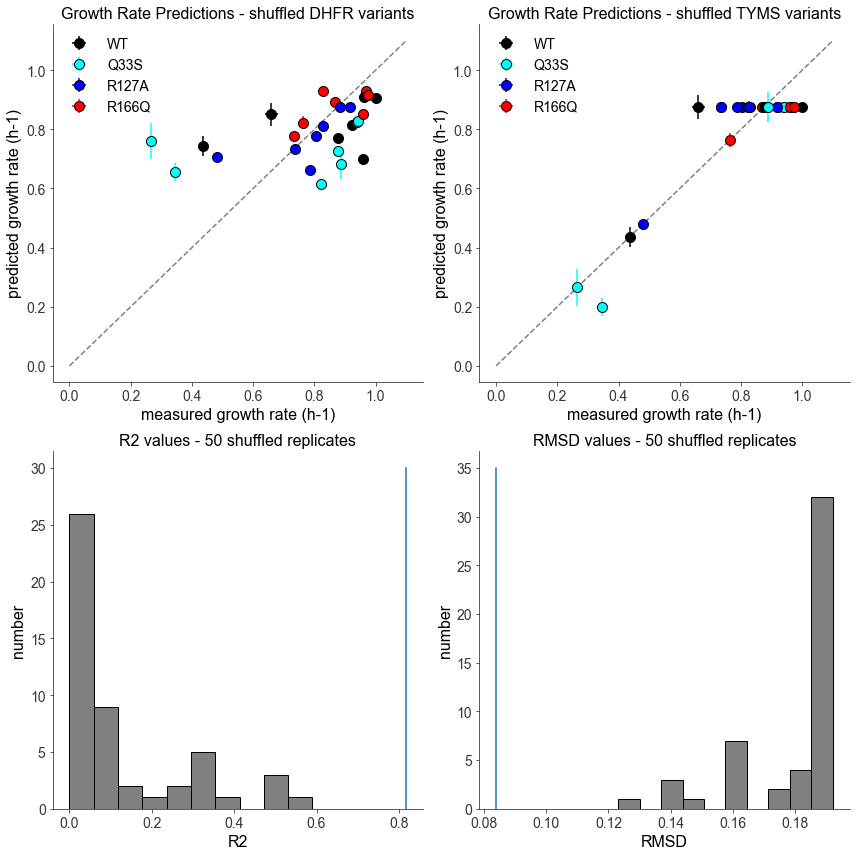

In [17]:
#### Shuffle DHFR catalytic parameters only ##################
DHFR_shuff = np.arange(len(dhkcat_sel))
np.random.shuffle(DHFR_shuff)
dhkcat_shuff = [dhkcat_sel[i] for i in DHFR_shuff]
dhkm_shuff = [dhkm_sel[i] for i in DHFR_shuff]

#perform the fit
kg_dhshuff = least_squares(resids_grates,p0,\
                            args=(tskcat_sel,dhkcat_shuff,tskm_sel,dhkm_shuff,g_rates_mean),\
                            bounds=bds)
        
gr_pred_dhshuff = calcGR(kg_dhshuff.x[0],kg_dhshuff.x[1],kg_dhshuff.x[1:5],kg_dhshuff.x[5],\
                        tskcat_sel,dhkcat_shuff,tskm_sel,dhkm_shuff,kg_dhshuff.x[6:])

#assess model fit quality
rmsd_allfit2 = np.sqrt(np.sum((gr_pred_dhshuff - g_rates_mean)**2)/N_meas)
r2_allfit2 = np.corrcoef(g_rates_mean.flatten(),gr_pred_dhshuff.flatten())[0,1]**2
print('*** RMSD between the model and data - using refit params for full model: %1.2f' % rmsd_allfit2)
print('*** R2: %1.2f' % r2_allfit2)

#plot the results
plt.figure(figsize=(12,12))
plt.subplot(221)
for i,dmut in enumerate(DHFR_mut):
    for k,tmut in enumerate(TYMS_mut):
        if i==0:
            plt.errorbar(g_rates_mean[i,k],gr_pred_dhshuff[i,k],xerr=g_rates_std[i,k],
                     yerr = gr_pred_allfit2_err[i,k],marker='o',mec='k',color=ts_col[k],markersize=10,
                         linestyle='',label=tmut)
        else:
            plt.errorbar(g_rates_mean[i,k],gr_pred_dhshuff[i,k],xerr=g_rates_std[i,k],
                     yerr = gr_pred_allfit2_err[i,k],marker='o',mec='k',color=ts_col[k],markersize=10,
                         linestyle='')
plt.legend()
plt.plot([0,1.1],[0,1.1],'--',color='grey')
plt.title('Growth Rate Predictions - shuffled DHFR variants', fontsize=16)
plt.xlabel('measured growth rate (h-1)', fontsize=16)
plt.ylabel('predicted growth rate (h-1)', fontsize=16)

#### Shuffle TYMS catalytic parameters only ####################
TYMS_shuff = np.arange(len(tskcat_sel))
np.random.shuffle(TYMS_shuff)
tskcat_shuff = [tskcat_sel[i] for i in TYMS_shuff]
tskm_shuff = [tskm_sel[i] for i in TYMS_shuff]

#perform the fit
kg_tsshuff = least_squares(resids_grates,p0,\
                            args=(tskcat_shuff,dhkcat_sel,tskm_shuff,dhkm_sel,g_rates_mean),\
                            bounds=bds)
        
gr_pred_tsshuff = calcGR(kg_tsshuff.x[0],kg_tsshuff.x[1],kg_tsshuff.x[1:5],kg_tsshuff.x[5],\
                        tskcat_shuff,dhkcat_sel,tskm_shuff,dhkm_sel,kg_tsshuff.x[6:])

#assess model fit quality
rmsd_allfit2 = np.sqrt(np.sum((gr_pred_tsshuff - g_rates_mean)**2)/N_meas)
r2_allfit2 = np.corrcoef(g_rates_mean.flatten(),gr_pred_tsshuff.flatten())[0,1]**2
print('*** RMSD between the model and data - using refit params for full model: %1.2f' % rmsd_allfit2)
print('*** R2: %1.2f' % r2_allfit2)

#plot the results
plt.subplot(222)
for i,dmut in enumerate(DHFR_mut):
    for k,tmut in enumerate(TYMS_mut):
        if i==0:
            plt.errorbar(g_rates_mean[i,k],gr_pred_tsshuff[i,k],xerr=g_rates_std[i,k],
                     yerr = gr_pred_allfit2_err[i,k],marker='o',mec='k',color=ts_col[k],markersize=10,
                         linestyle='',label=tmut)
        else:
            plt.errorbar(g_rates_mean[i,k],gr_pred_tsshuff[i,k],xerr=g_rates_std[i,k],
                     yerr = gr_pred_allfit2_err[i,k],marker='o',mec='k',color=ts_col[k],markersize=10,
                         linestyle='')
plt.legend()
plt.plot([0,1.1],[0,1.1],'--',color='grey')
plt.title('Growth Rate Predictions - shuffled TYMS variants', fontsize=16)
plt.xlabel('measured growth rate (h-1)', fontsize=16)
plt.ylabel('predicted growth rate (h-1)', fontsize=16)

#### Now try random shufflings of both DHFR and TYMS catalytic parameters #####################
Nshuff = 50
rmsd_shuff = []
r2_shuff = []

for i in range(Nshuff):
    DHFR_shuff = np.arange(len(dhkcat_sel))
    np.random.shuffle(DHFR_shuff)
    dhkcat_shuff = [dhkcat_sel[i] for i in DHFR_shuff]
    dhkm_shuff = [dhkm_sel[i] for i in DHFR_shuff]
    
    TYMS_shuff = np.arange(len(tskcat_sel))
    np.random.shuffle(TYMS_shuff)
    tskcat_shuff = [tskcat_sel[i] for i in TYMS_shuff]
    tskm_shuff = [tskm_sel[i] for i in TYMS_shuff]
    
    kg_shuff = least_squares(resids_grates,p0,\
                                args=(tskcat_shuff,dhkcat_shuff,tskm_shuff,dhkm_shuff,g_rates_mean),\
                                bounds=bds)

    gr_pred_shuff = calcGR(kg_shuff.x[0],kg_shuff.x[1],kg_shuff.x[1:5],kg_shuff.x[5],\
                            tskcat_shuff,dhkcat_shuff,tskm_shuff,dhkm_shuff,kg_shuff.x[6:])

    #assess model fit quality
    rmsd_shuff.append(np.sqrt(np.sum((gr_pred_shuff - g_rates_mean)**2)/N_meas))
    r2_shuff.append(np.corrcoef(g_rates_mean.flatten(),gr_pred_shuff.flatten())[0,1]**2)
    
    
#plot the distribution of R2 values for shuffled data, and indicate the actual best fit
plt.subplot(223)
plt.hist(r2_shuff, edgecolor='k',color='grey')
plt.plot([r2_allfit2,r2_allfit2],[0,30],)
plt.title('R2 values - 50 shuffled replicates', fontsize=16)
plt.xlabel('R2', fontsize=16); plt.ylabel('number', fontsize=16)

#plot the distribution of RMSD values for shuffled data, and indicate the actual best fit
plt.subplot(224)
plt.hist(rmsd_shuff,edgecolor='k',color='grey')
plt.plot([rmsd_allfit2,rmsd_allfit2],[0,35],)
plt.title('RMSD values - 50 shuffled replicates', fontsize=16)
plt.xlabel('RMSD', fontsize=16)
plt.ylabel('number', fontsize=16)

plt.tight_layout()
plt.savefig('Figs/KGModelPlateData_Shuffle.pdf')

As expected, the model is reasonably robust to shuffling the TYMS biochemical parameters, because we fit a seperate TYMS concentration parameter for each mutation (that can compensate). The model is not robust to shuffling the DHFR values. This suggests that the TYMS portion of the model may be overfit. <br>

If we constrain the model to only fit a single TYMS concentration, the overall correlation between predicted and measured growth rates remains high (R2 = 0.93), and the model no longer works well when TYMS values are shuffled. However, we lose the prediction of negative epistasis to TYMS Q33S, which is a key outcome of our model (and experiments). For this reason, we continue with a version of the model that seperately fits concentrations for each TYMS variant.

We also visualize the growth rate and epistasis predictions for our best fit model as a heatmap. 

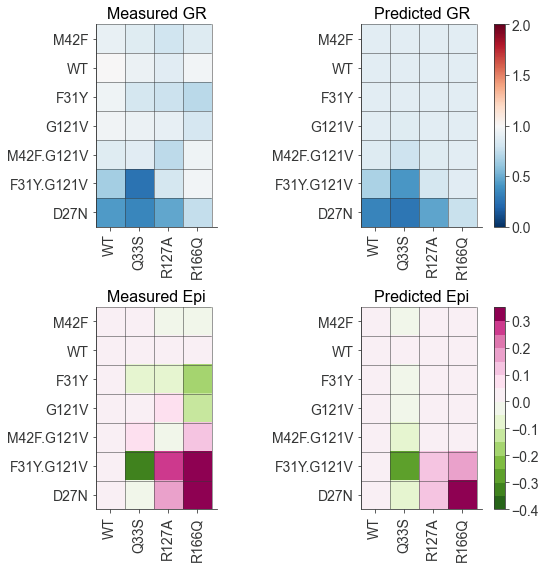

In [18]:
plt.figure(num='h2',figsize=(8,8))
#divnorm = colors.TwoSlopeNorm(vmin=-0.25, vcenter=0, vmax=0.6)
bounds = np.arange(-0.4, 0.4, 0.05)
base = plt.cm.get_cmap('PiYG_r')
cmap_discrete = base(np.linspace(0,1,len(bounds)))
newmap = colors.ListedColormap(cmap_discrete)
newmap.set_bad(color='grey') 
norm_epi = colors.BoundaryNorm(bounds,newmap.N)

plt.subplot(2,2,1)
plt.imshow(g_rates_mean,vmin=0, vmax=2,cmap='RdBu_r')
plot_style.grid_maker(g_rates_mean,'h2')
plt.yticks(np.arange(0,len(DHFR_mut)),\
                             labels=DHFR_mut)
plt.xticks(np.arange(0,len(TYMS_mut)),\
                             labels=TYMS_mut,\
                             rotation='vertical')
plt.title('Measured GR', fontsize=16)

plt.subplot(2,2,2)
plt.imshow(gr_pred_allfit2,vmin=0, vmax=2,cmap='RdBu_r')
plot_style.grid_maker(g_rates_mean,'h2')
plt.yticks(np.arange(0,len(DHFR_mut)),\
                             labels=DHFR_mut)
plt.xticks(np.arange(0,len(TYMS_mut)),\
                             labels=TYMS_mut,\
                             rotation='vertical')
plt.title('Predicted GR', fontsize=16)
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(epi_meas,norm=norm_epi,cmap=newmap)
plot_style.grid_maker(g_rates_mean,'h2')
plt.yticks(np.arange(0,len(DHFR_mut)),\
                             labels=DHFR_mut)
plt.xticks(np.arange(0,len(TYMS_mut)),\
                             labels=TYMS_mut,\
                             rotation='vertical')
plt.title('Measured Epi', fontsize=16)

plt.subplot(2,2,4)
plt.imshow(epi_pred,norm=norm_epi,cmap=newmap)
plot_style.grid_maker(g_rates_mean,'h2')
plt.yticks(np.arange(0,len(DHFR_mut)),\
                             labels=DHFR_mut)
plt.xticks(np.arange(0,len(TYMS_mut)),\
                             labels=TYMS_mut,\
                             rotation='vertical')
plt.title('Predicted Epi', fontsize=16)
plt.colorbar()
plt.tight_layout()
plt.savefig('Figs/KGModelPlateData_Heatmaps.pdf')

### 6. Evaluate the origins of sign epistasis between DHFR and TYMS

#### Plots of the growth rate and epistasis landscapes as a function of DHFR kcat and KM

Here the goal is to build some intuition regarding the origins of negative epistasis, and more completely understand the relationship between DHFR activity and growth rate.

In [19]:
#vary over DHFR kcat and DHFR Km
dhkcat_vary = np.logspace(-2,2,25)
dhKm_vary = np.logspace(-1,2.6,25)

gr_varydh = {}
for i,ts in enumerate(TYMS_mut):
    gr_varydh[ts] = np.zeros((len(dhkcat_vary),len(dhKm_vary)))

    #ompute the predicted thf concentration and growth rate for every kcat, Km combination
    #(across each TYMS background)
    for j,kcat in enumerate(dhkcat_vary):
        for k,km in enumerate(dhKm_vary):
            gr = calcGR(Ftot_all2,c_ts_all2[0],c_ts_all2[i],c_dh_all2,TYMS_kcat[ts],kcat,TYMS_Km[ts],km,g_params_all2)
            gr_varydh[ts][j,k] = gr

#Now - we go back and calculate growth rate epistasis for the different TYMS variants
epi_varydh = {}
sig_epi_kcat = {}
sig_epi_kcatKm = {}
for i,ts in enumerate(TYMS_mut):
    epi_varydh[ts] = np.zeros((len(dhkcat_vary),len(dhKm_vary)))
    sig_epi_kcat[ts] = []
    sig_epi_kcatKm[ts] = []
    if ts == 'WT':
        kcat_grid = np.zeros((len(dhkcat_vary),len(dhKm_vary)))
        km_grid = np.zeros((len(dhkcat_vary),len(dhKm_vary)))
        for j,dkcat in enumerate(dhkcat_vary):
            for k,dkm in enumerate(dhKm_vary):
                epi_varydh[ts][j,k] = gr_varydh[ts][j,k] + (gr_pred_allfit2[1,0] - gr_pred_allfit2[1,i] - gr_varydh['WT'][j,k])
                kcat_grid[j,k] = dkcat
                km_grid[j,k] = dkm

    else:
        for j,dkcat in enumerate(dhkcat_vary):
            for k,dkm in enumerate(dhKm_vary):
                epi_varydh[ts][j,k] = gr_varydh[ts][j,k] + (gr_pred_allfit2[1,0] - gr_pred_allfit2[1,i] - gr_varydh['WT'][j,k])
                if np.abs(epi_varydh[ts][j,k]) > 0.15:
                    sig_epi_kcat[ts].append(dkcat)
                    sig_epi_kcatKm[ts].append(dkcat/dkm)

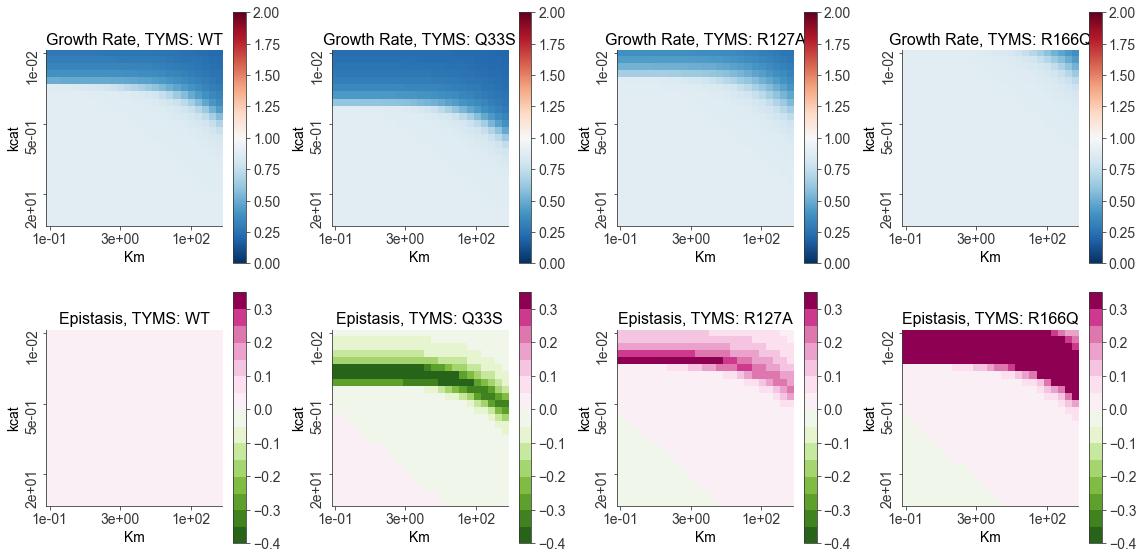

In [20]:
#create heatmaps of growth rate and epistasis as a function of DHFR kcat and Km
#for each of the four TYMS backgounds
plt.figure(num='h3',figsize=(16,8))
for i,ts in enumerate(TYMS_mut):
    plt.subplot(2,4,(i+1))
    plt.imshow(gr_varydh[ts],cmap='RdBu_r',vmax=2,vmin=0)
    plt.title('Growth Rate, TYMS: '+ts,fontsize=16)
    plt.yticks(np.arange(0,len(dhkcat_vary),10),rotation='vertical',\
                             labels=['%1.0e' %dhkcat_vary[i] for i in np.arange(0,len(dhkcat_vary),10)])
    plt.xticks(np.arange(0,len(dhKm_vary),10),\
                             labels=['%1.0e' %dhKm_vary[i] for i in np.arange(0,len(dhKm_vary),10)])
    plt.colorbar()
    plt.ylabel('kcat',fontsize=14)
    plt.xlabel('Km',fontsize=14)
    

    plt.subplot(2,4,(i+5))
    plt.imshow(epi_varydh[ts],cmap=newmap,norm=norm_epi)
    plt.title('Epistasis, TYMS: '+ts,fontsize=16)
    plt.yticks(np.arange(0,len(dhkcat_vary),10),rotation='vertical',\
                             labels=['%1.0e' %dhkcat_vary[i] for i in np.arange(0,len(dhkcat_vary),10)])
    plt.xticks(np.arange(0,len(dhKm_vary),10),\
                             labels=['%1.0e' %dhKm_vary[i] for i in np.arange(0,len(dhKm_vary),10)])
    plt.colorbar()
    plt.ylabel('kcat',fontsize=14)
    plt.xlabel('Km',fontsize=14)


plt.tight_layout()
plt.savefig('Figs/KGModel_DHvaryHeatMaps.pdf')

In [21]:
#save the best model fit parameters to file (pickle)
model_fitplatedata  = {}
model_fitplatedata['Ftot'] = Ftot_all2
model_fitplatedata['c_ts'] = c_ts_all2
model_fitplatedata['c_dh'] = c_dh_all2
model_fitplatedata['g_params'] = g_params_all2

today = date.today()    
fout = open(f'Output/{today}_model_fitplatedata.pkl', 'wb')
pickle.dump(model_fitplatedata, fout, protocol=pickle.HIGHEST_PROTOCOL)
fout.close()